In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X_train = np.loadtxt('train_X.csv', delimiter=',').T
Y_train = np.loadtxt('train_Y.csv', delimiter=',').T

X_test = np.loadtxt('test_X.csv', delimiter=',').T
Y_test = np.loadtxt('test_Y.csv', delimiter=',').T

X_train = X_train/255.0
X_test  = X_test/255.0


In [5]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(784, 1000)
(10, 1000)
(784, 350)
(10, 350)


715


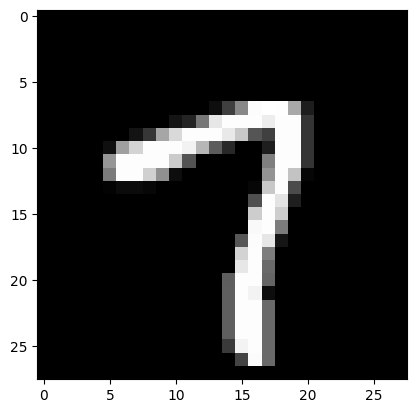

In [6]:
index = int(np.random.uniform(low = 0,high = X_train.shape[1], size = 1))
print(index)
plt.imshow(X_train[:, index].reshape(28,28), cmap = 'gray')
plt.show()

In [7]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def softmax(x):
    expX = np.exp(x)
    return expX/np.sum(expX, axis = 0)

def deriv_tanh(x):  
    return (1 - np.power(np.tanh(x), 2))

def relu(x):
    return np.maximum(x, 0)

def deriv_relu(x):
    return np.array(x > 0, dtype = np.float32)

In [23]:
def initialize_weights_and_biases(layer_dimensions):
    
    L = len(layer_dimensions) # total number of layers (including input layer)

    weights_and_biases = {}

    for i in range(1, L): # loop over
        weights_and_biases[f'W{i}'] = np.random.randn(layer_dimensions[i], layer_dimensions[i-1]) / np.sqrt(layer_dimensions[i-1])
        weights_and_biases[f'B{i}'] = np.zeros((layer_dimensions[i], 1))

    return weights_and_biases



In [3]:
def forward_propagation(input, weights_and_biases, activation_function = 'relu'):

    if activation_function == 'relu':
        def Activation_Function(x):
            return relu(x)
    elif activation_function == 'tanh':
        def Activation_Function(x):
            return np.tanh(x)


    x = input

    L = len(weights_and_biases)//2  #dividing by 2 because dictionary contains 
                                    #a weight and a biase for each layer
    
    forward_prop_dict = {}

    forward_prop_dict['A0'] = x


    for i in range(1, L):
        forward_prop_dict[f'Z{i}'] = weights_and_biases[f'W{i}'] @ forward_prop_dict[f'A{i-1}'] + weights_and_biases[f'B{i}']
        forward_prop_dict[f'A{i}'] = Activation_Function(forward_prop_dict[f'Z{i}'])
    
    forward_prop_dict[f'Z{L}'] = weights_and_biases[f'W{L}'] @ forward_prop_dict[f'A{L-1}'] + weights_and_biases[f'B{L}']
    
    if forward_prop_dict[f'Z{L}'].shape[0] == 1:
        forward_prop_dict[f'A{L}'] = sigmoid(forward_prop_dict[f'Z{L}'])
    else:
        forward_prop_dict[f'A{L}'] = softmax(forward_prop_dict[f'Z{L}'])

    return forward_prop_dict[f'A{L}'], forward_prop_dict

In [25]:
def cost_function(AL, y):
    # Batch size: m
    m = y.shape[1]

    #Check if binary classification:
    if y.shape[0] > 1:
        cost = -(1/m)*np.sum(y*np.log(AL))
    else:
        cost = -(1/m)*np.sum(y*np.log(AL) + (1-y)*np.log(1-AL))

    # [[[0]]] -> [0]
    return np.squeeze(cost)

In [26]:
def back_propagation(x, y, weights_and_biases, forward_prop_dict, activation_function):
    
    if activation_function == 'relu':
        def derivative_Activation_Function(x):
            return deriv_relu(x)
    elif activation_function == 'tanh':
        def derivative_Activation_Function(x):
            return deriv_tanh(x)

    
    gradients = {}
    L = len(weights_and_biases)//2    
    m = x.shape[1]

    gradients[f'dZ{L}'] = forward_prop_dict[f'A{L}'] - y
    gradients[f'dW{L}'] = (1/m) * gradients[f'dZ{L}'] @ forward_prop_dict[f'A{L-1}'].T
    gradients[f'dB{L}'] = (1/m) * np.sum(gradients[f'dZ{L}'], axis=1, keepdims=True) 

    #Calculate gradients backwards therefore count backwards
    for l in range(L-1, 0, -1):
        gradients[f'dZ{l}'] = weights_and_biases[f'W{l+1}'].T @ gradients[f'dZ{l+1}'] * derivative_Activation_Function(forward_prop_dict[f'Z{l}'])
        gradients[f'dW{l}'] = (1/m)*gradients[f'dZ{l}'] @ forward_prop_dict[f'A{l-1}'].T
        gradients[f'dB{l}'] = (1/m) * np.sum(gradients[f'dZ{l}'], axis=1, keepdims=True) 
    

    return gradients
    

In [27]:
def update_weights_and_biases(weights_and_biases, gradients, learning_rate):
    
    L = len(weights_and_biases)//2    

    a = learning_rate
    for l in range(1, L):
        weights_and_biases[f'W{l}'] = weights_and_biases[f'W{l}'] - a*gradients[f'dW{l}']
        weights_and_biases[f'B{l}'] = weights_and_biases[f'B{l}'] - a*gradients[f'dB{l}']
    
    return weights_and_biases



In [6]:
def measureAccuracy(input, labels, weights_and_biases):
    AL, prediction_dict = forward_propagation(input, weights_and_biases, activation_function = 'relu') 
    AL_max_index = np.argmax(AL, 0)
    label = np.argmax(labels, 0)

    accuracy = np.mean(AL_max_index == label)*100

    return(accuracy)

In [29]:
def train_model(x_train, y_train, layer_dimensions, learning_rate, epochs, batch_size, activation_function = 'relu'):

    
    weights_and_biases = initialize_weights_and_biases(layer_dimensions)

    L = len(layer_dimensions)-1

    costList = []

    x_train = x_train.reshape(x_train.shape[0], batch_size, -1)
    y_train = y_train.reshape(y_train.shape[0], batch_size, -1)
    print(x_train.shape)

    iterations = x_train.shape[2]

    for j in range(epochs):
        for i in (range(iterations)):
            x = x_train[:,:,i]
            y = y_train[:,:,i]

            AL, forward_prop_dict = forward_propagation(x, weights_and_biases, activation_function=activation_function)

            cost = cost_function(AL, y)

            gradients = back_propagation(x, y, weights_and_biases, forward_prop_dict, activation_function=activation_function)

            weights_and_biases = update_weights_and_biases(weights_and_biases, gradients, learning_rate)

            costList.append(cost)
        
            if i % 1000 == 0:
                print(f'{(j+1)*(i+1)*1000}/{epochs*iterations} Train_Acc: {round(measureAccuracy(X_train, Y_train, weights_and_biases),2)}, Test_Acc: {round(measureAccuracy(X_test, Y_test, weights_and_biases),2)}\r', end="")
                # print 'Downloading File FooFile.txt [%d%%]\r'
            # if i % 70 == 0:
                # print("--", end='')

    return weights_and_biases, costList


In [30]:
epochs = 70
learning_rate = 0.02
batch_size = 1
trained_weights_and_biases, costList = train_model(X_train, Y_train, [X_train.shape[0], 500, 500, Y_train.shape[0]], learning_rate = learning_rate, epochs = epochs, batch_size = batch_size, activation_function = 'relu')

(784, 1, 1000)

In [34]:
# Save the dictionary of arrays to an .npz file
# np.savez('MNISTdata.npz', **trained_weights_and_biases)

In [4]:
# To load the data back into a dictionary
loaded_data = np.load('MNISTdata.npz')

trained_weights_and_biases = {key: loaded_data[key] for key in loaded_data.files}

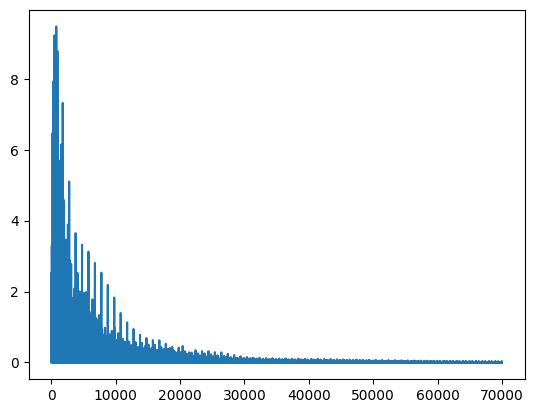

In [31]:
t = np.arange(0, len(costList))
plt.plot(t, costList)
plt.show()

In [7]:
print("Training Accuracy", measureAccuracy(X_train, Y_train, trained_weights_and_biases))
print("Testing Accuracy", measureAccuracy(X_test, Y_test, trained_weights_and_biases))

NameError: name 'relu' is not defined

300


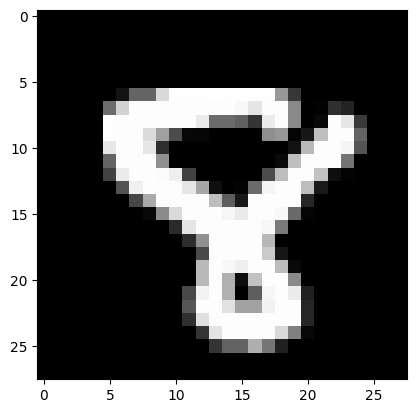

[array([8], dtype=int64)]


In [18]:
index = int(np.random.uniform(low = 0,high = X_test.shape[1], size = 1))
print(index)
plt.imshow(X_test[:, index].reshape(28,28), cmap = 'gray')
plt.show()

image = X_test[:, index]

MNISTSet = [0,1,2,3,4,5,6,7,8,9]

AL, prediction_dict = forward_propagation(image.reshape(X_test.shape[0], 1), trained_weights_and_biases, activation_function = 'relu') 
print([np.argmax(AL,0)])